In [1]:
# Import dependencies
import networkx as nx
import pandas as pd
import numpy as np
import time as tm
import math as math
import matplotlib.pyplot as plt
import simpy
from openpyxl import load_workbook
from openpyxl.utils.cell import range_boundaries
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import random
from matplotlib.animation import FuncAnimation
import json
%matplotlib inline

# Part 1: Excel to node graph (Cost matrix)

In [2]:
# Globals
DesignFile = 'modified_map5.xlsx'  
DesignWorksheet = 'Sheet1' 
DesignRange = 'test'   
IntMultiplier = 1000  
Avgwalk = 100 # meter per min

### Load file map grid excel

In [3]:
# Load layout from Excel file to pandas dataframe
def LoadFromExcel(ExcelFile, Worksheet, Range):
    wb = load_workbook(filename=ExcelFile, read_only=True)
    ws = wb[Worksheet]
    dests = wb.defined_names[Range].destinations
    for title, coord in dests:
        min_col, min_row, max_col, max_row = range_boundaries(coord)
        data = ws.iter_rows(min_row, max_row, min_col, max_col, values_only=True)
    ExcelData = pd.DataFrame(data)
    return ExcelData

### Add label

In [4]:
# Create array of cell number labels.
# Cells are labelled from west-to-east and from north-to-south. row1.e. top-left = 1, bottom-right = n
def ApplyLabels(rows, columns):
    currLabel = 1
    data = []
    for r in range(0, rows):
        column = []
        for c in range(0, columns):
            column.append(str(currLabel))
            currLabel += 1
        data.append(column)
    labels = pd.DataFrame(data)
    return labels


#### This method invert each cell in excel to nodes and assume distance between node = 5 meters

In [5]:
# Build edgelist
def ConstructAdjacency(Layout, Labels, rows, columns):
    node1 = []
    node2 = []
    weight = []
    cardinal = 5
    diagoanal = 5*(2**0.5)

    for row1 in range(rows):
        for column1 in range(columns):
            if Layout.loc[row1,column1].lower() in ('start','end','w'):
                for row2 in range(rows):
                    for column2 in range(columns):
                        if Layout.loc[row2,column2].lower() in ('start','end','w'):
                            # check if adjacent
                            if (abs(row2-row1) <= 1) and (abs(column2-column1) <= 1) and not(row1 == row2 and column1 == column2):
                                node1.append(Labels.loc[row1,column1])
                                node2.append(Labels.loc[row2,column2])
                                # add weight
                                if (row1 == row2) or (column1 == column2):
                                    weight.append(cardinal)
                                else:
                                    weight.append(diagoanal)
    
    edgelist = pd.DataFrame({
        'node1': node1,
        'node2': node2,
        'weights':weight
    })
    return edgelist

In [6]:
# Create adjacency graph
def CreateGraph(Adjacency):
    g = nx.DiGraph()
    for i, elrow in Adjacency.iterrows():
        g.add_edge(elrow['node1'], elrow['node2'], stepsize=round(elrow['weights'],3))
    return g


In [7]:
def SpotMatrix(Layout, Labels, rows, columns):
    name = []
    Cell = []
    Spot = []
    row_column = []
    cartesian = []
    name_count = 0
    for row1 in range(rows):
        for column1 in range(columns):
            if Layout.loc[row1, column1].lower() == 's':
                cardinal_neighbors = [(row1-1, column1), # North
                                      (row1+1, column1), # South
                                      (row1, column1-1), # West
                                      (row1, column1+1)] # East
                for row2, column2 in cardinal_neighbors:
                    if 0 <= row2 < rows and 0 <= column2 < columns:  # Ensure within bounds
                        if Layout.loc[row2, column2].lower() == 'w':
                            Cell.append(Labels.loc[row1, column1])
                            Spot.append(Labels.loc[row2, column2])
                            row_column.append((row2, column2))  # Add row_column coordinates
                            cartesian.append((column2,-row2))
                            name.append(name_count)
                            name_count += 1
                            
    edgelist = pd.DataFrame({'name': name, 'Cell': Cell, 'Spot': Spot, 'row_column': row_column, 'Cartesian': cartesian})
    #just swap depot @ 7 to 0
    temp_row = edgelist.loc[0, ['Cell', 'Spot', 'row_column', 'Cartesian']].copy()
    edgelist.loc[0, ['Cell', 'Spot', 'row_column', 'Cartesian']] = edgelist.loc[7, ['Cell', 'Spot', 'row_column', 'Cartesian']]
    edgelist.loc[7, ['Cell', 'Spot', 'row_column', 'Cartesian']] = temp_row
    return edgelist

In [8]:
# Shortest distance between two spots, using networkx
def NetworkxPath(DesignGraph, input_node, output_node):
    PathLength = nx.shortest_path_length(DesignGraph, source = input_node, target = output_node, weight='stepsize')
    return PathLength

In [9]:
# Create matrix of shortest paths between all spot cells
def Distances(Spots, DesignGraph):
    ShortestPaths = pd.DataFrame(index=range(len(Spots)), columns=range(len(Spots)))
    for row in range(len(Spots)):
        for column in range(len(Spots)):
            if row == column:
                ShortestPaths.at[row,column] = 0
            else:
                PathLength = NetworkxPath(DesignGraph, Spots.loc[row]['Spot'], Spots.loc[column]['Spot'])
                Decimals = round(math.log(IntMultiplier,10))
                ShortestPaths.at[row, column] = round(PathLength, Decimals)   # Upper-right triangle of matrix
                ShortestPaths.at[column, row] = round(PathLength, Decimals)   # Lower-left triangle of matrix
    dist = ShortestPaths.astype(int)
    dist = dist / Avgwalk
    return dist

### Visualize node graph from cost matrix

In [10]:
def plot_spots_with_cartesian(edgelist, distance_matrix):
    G = nx.Graph()

    # Add nodes to the graph
    G.add_nodes_from(edgelist['name'])

    # Extract depot and elements
    depot = edgelist.iloc[0]
    elements = edgelist.drop(0)

    # Create a dictionary for node positions
    pos = {row['name']: row['Cartesian'] for _, row in edgelist.iterrows()}

    # Add fully connected edges using the distance matrix
    for i in range(len(distance_matrix)):
        for j in range(i + 1, len(distance_matrix)):
            node_i = edgelist.iloc[i]['name']
            node_j = edgelist.iloc[j]['name']
            distance = distance_matrix.iloc[i, j]
            G.add_edge(node_i, node_j, weight=distance)

    # Plot settings
    plt.figure(figsize=(10, 10))  # Increase figure size

    # Plot the depot node in red
    nx.draw_networkx_nodes(G, pos, nodelist=[depot['name']], node_color='red', node_size=500)

    # Plot the other spot nodes in blue
    nx.draw_networkx_nodes(G, pos, nodelist=elements['name'], node_color='blue', node_size=500)

    # Add labels to the nodes
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

    # Draw the edges with a thicker line width
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=2)

    # Optionally, add edge labels for distances
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    # Show the plot
    plt.grid(True)  # Optionally add a grid for better readability
    plt.show()

    #return G, pos

    0  1  2  3  4  5  6  7  8  9   ... 54 55 56 57 58 59 60 61 62 63
0    b  b  b  b  b  b  b  b  b  b  ...  b  b  b  b  b  b  b  b  b  b
1    b  n  n  n  n  n  n  n  n  n  ...  o  o  n  n  n  n  n  n  n  n
2    b  n  n  n  n  n  n  n  n  n  ...  o  o  n  n  n  n  n  n  n  n
3    b  n  n  n  n  n  n  n  n  n  ...  o  o  n  n  n  n  n  n  n  n
4    b  n  n  n  n  n  n  n  n  n  ...  o  o  n  n  n  n  n  n  n  n
..  .. .. .. .. .. .. .. .. .. ..  ... .. .. .. .. .. .. .. .. .. ..
105  b  g  g  g  g  g  g  g  g  g  ...  m  m  m  m  m  m  m  m  w  w
106  b  g  g  g  g  g  g  g  g  g  ...  m  m  m  m  m  m  m  m  w  w
107  b  w  w  w  w  w  w  w  w  w  ...  w  w  w  w  w  w  w  w  w  w
108  b  w  w  w  w  w  w  w  w  w  ...  w  w  w  w  w  w  w  w  w  w
109  b  b  b  b  b  b  b  b  b  b  ...  b  b  b  b  b  b  b  b  b  b

[110 rows x 64 columns]

rows 110 columns 64
       0     1     2     3     4     5     6     7     8     9   ...    54  \
0       1     2     3     4     5     6     7   

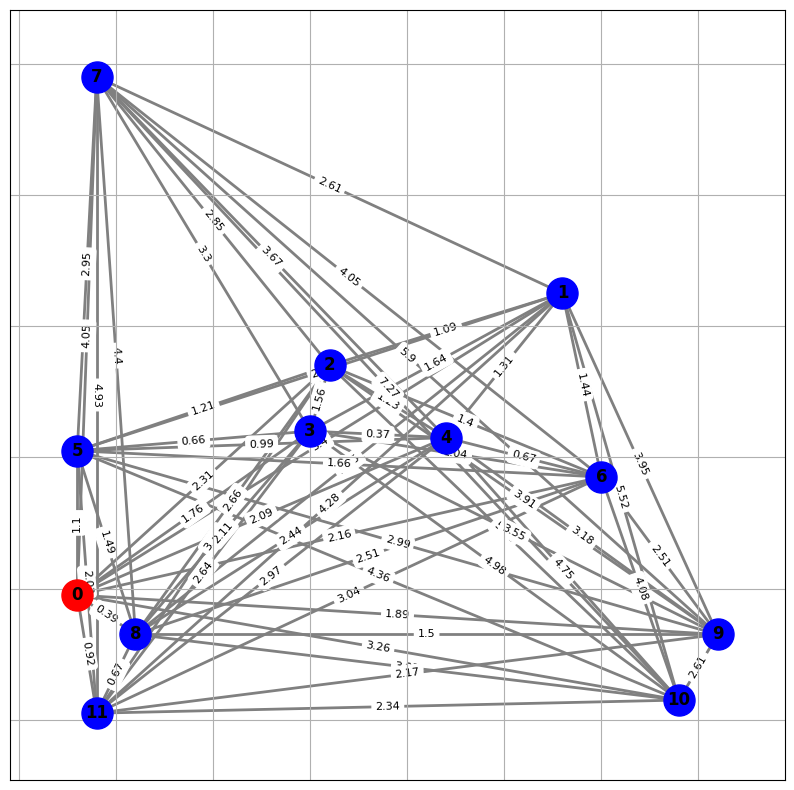

In [11]:
def main():
    Layout = LoadFromExcel(DesignFile,DesignWorksheet,DesignRange)   
    print(Layout)

    rows,columns = Layout.shape
    print(f"\nrows {rows} columns {columns}")

    Labels = ApplyLabels(rows, columns)
    print(Labels)
    
    Adjacency = ConstructAdjacency(Layout, Labels, rows, columns)
    print(Adjacency)

    DesignGraph = CreateGraph(Adjacency)
    print(DesignGraph)

    Spots = SpotMatrix(Layout, Labels, rows, columns)
    print(Spots)

    timematrix = Distances(Spots, DesignGraph) # multiply with walk factor
    print(timematrix)

    plot_spots_with_cartesian(Spots, timematrix)
    
    return Spots, timematrix
    
Spots, timematrix = main()

# Part 2: Simulation VRP

## No Time Window and No Capacity Constraints

### Nearest Neighbor Algorithm

The Nearest Neighbor algorithm is a heuristic method used to solve the Vehicle Routing Problem (VRP). It aims to find a feasible solution by iteratively selecting the nearest unvisited location as the next stop.

#### Considerations:

- **No Time Window:** The algorithm does not account for any specific time constraints for visiting locations. The focus is solely on minimizing travel distance or time.
  
- **No Capacity Constraints:** There are no restrictions on the capacity of the vehicle, allowing for an unrestricted number of stops or deliveries.

In [12]:
Spots_df = Spots  # DataFrame with spot locations, for animation
time_matrix = timematrix  # Time matrix between nodes
num_vehicles = 4
depot_index = 0
max_time_per_vehicle = 50

class Customer:
    def __init__(self, id):
        self.id = id

class Vehicle:
    def __init__(self, env, id, depot_index, max_time):
        self.env = env
        self.id = id
        self.current_location = depot_index
        self.route = []
        self.time_spent = 0
        self.max_time = max_time
        self.finished = False
        self.served_customers = []

    def travel_to(self, customer_index):
        travel_time = time_matrix[self.current_location][customer_index]
        yield self.env.timeout(travel_time)
        self.time_spent += travel_time
        self.current_location = customer_index
        print(f"Vehicle {self.id} traveled to customer {customer_index} at time {self.env.now}")

    def serve_customer(self, customer):
        service_time = 1  # Fixed service time
        yield self.env.timeout(service_time)
        self.time_spent += service_time
        print(f"Vehicle {self.id} served customer {customer} at time {self.env.now}")

    def run(self):
        while not self.finished:
            if not self.route:
                yield self.env.timeout(1)  # Wait for new assignments
                continue

            next_customer_index = self.route.pop(0)
            # Travel to the next customer
            yield self.env.process(self.travel_to(next_customer_index))
            # Serve the next customer
            yield self.env.process(self.serve_customer(next_customer_index))
            # Record served customer
            self.served_customers.append(next_customer_index)
            # Return to depot if necessary
            if not self.route or self.time_spent + time_matrix[self.current_location][depot_index] > self.max_time:
                yield self.env.process(self.travel_to(depot_index))
                print(f"Vehicle {self.id} returned to depot at time {self.env.now}")
                self.finished = True

class NearestNeighborStrategy:
    def __init__(self, time_matrix, depot_index):
        self.time_matrix = time_matrix
        self.depot_index = depot_index

    def choose_route(self, vehicle, unvisited_customers):
        current_location = vehicle.current_location
        route = []
        while unvisited_customers:
            nearest_customer = min(
                unvisited_customers,
                key=lambda cust: self.time_matrix[current_location][cust]
            )
            route.append(nearest_customer)
            unvisited_customers.remove(nearest_customer)
            current_location = nearest_customer
        return route

def vrptw_simulation(env):
    vehicles = [Vehicle(env, i, depot_index, max_time_per_vehicle) for i in range(num_vehicles)]
    strategy = NearestNeighborStrategy(time_matrix, depot_index)
    
    # Create a list of unvisited customers
    unvisited_customers = [c for c in range(1, len(time_matrix))]
    
    # Assign routes to each vehicle using the Nearest Neighbor strategy
    for vehicle in vehicles:
        vehicle.route = strategy.choose_route(vehicle, unvisited_customers.copy())
        env.process(vehicle.run())

    while any(not v.finished for v in vehicles):
        yield env.timeout(1)

    all_results = {
        'served_customers': {v.id: v.served_customers for v in vehicles}
    }
    return all_results

# Create simulation environment
env = simpy.Environment()
results_process = env.process(vrptw_simulation(env))
env.run()

# Collect and display results
results = results_process.value
for vehicle_id, served_customers in results['served_customers'].items():
    print(f"Vehicle {vehicle_id} served customers: {served_customers}")



Vehicle 0 traveled to customer 8 at time 0.39
Vehicle 1 traveled to customer 8 at time 0.39
Vehicle 2 traveled to customer 8 at time 0.39
Vehicle 3 traveled to customer 8 at time 0.39
Vehicle 0 served customer 8 at time 1.3900000000000001
Vehicle 1 served customer 8 at time 1.3900000000000001
Vehicle 2 served customer 8 at time 1.3900000000000001
Vehicle 3 served customer 8 at time 1.3900000000000001
Vehicle 0 traveled to customer 11 at time 2.06
Vehicle 1 traveled to customer 11 at time 2.06
Vehicle 2 traveled to customer 11 at time 2.06
Vehicle 3 traveled to customer 11 at time 2.06
Vehicle 0 served customer 11 at time 3.06
Vehicle 1 served customer 11 at time 3.06
Vehicle 2 served customer 11 at time 3.06
Vehicle 3 served customer 11 at time 3.06
Vehicle 0 traveled to customer 5 at time 5.08
Vehicle 1 traveled to customer 5 at time 5.08
Vehicle 2 traveled to customer 5 at time 5.08
Vehicle 3 traveled to customer 5 at time 5.08
Vehicle 0 served customer 5 at time 6.08
Vehicle 1 serve

In [13]:
routes = results['served_customers']
for vehicle_id, route in routes.items():
    route.insert(0, 0)  # Add 0 at the start
    route.append(0)     # Add 0 at the end
# Print the updated routes
print(routes)

{0: [0, 8, 11, 5, 3, 4, 6, 2, 1, 7, 9, 10, 0], 1: [0, 8, 11, 5, 3, 4, 6, 2, 1, 7, 9, 10, 0], 2: [0, 8, 11, 5, 3, 4, 6, 2, 1, 7, 9, 10, 0], 3: [0, 8, 11, 5, 3, 4, 6, 2, 1, 7, 9, 10, 0]}


# Part3: Animation simulation 
### use result to animate graph

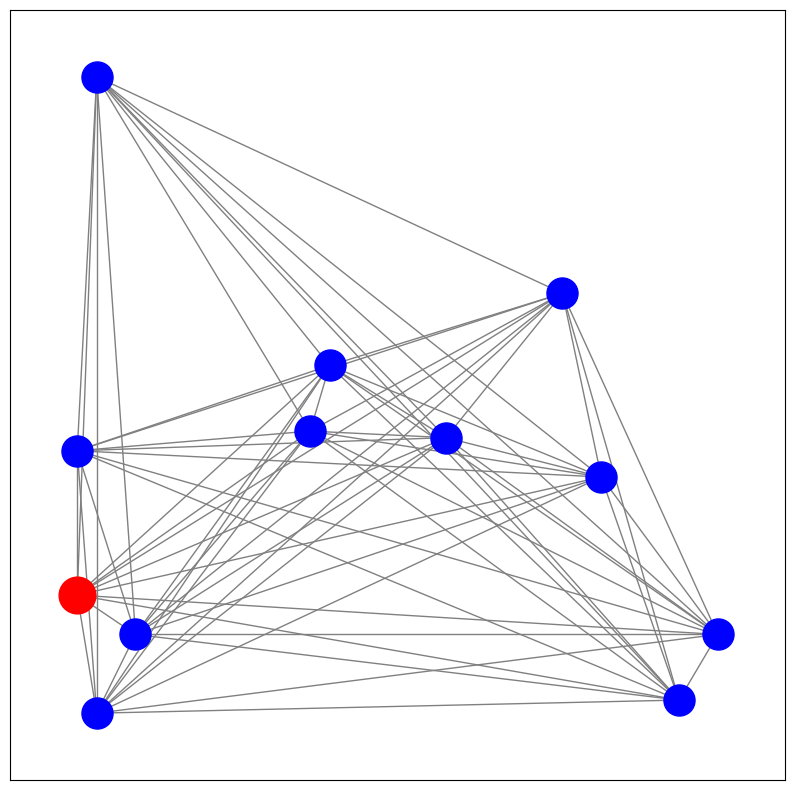

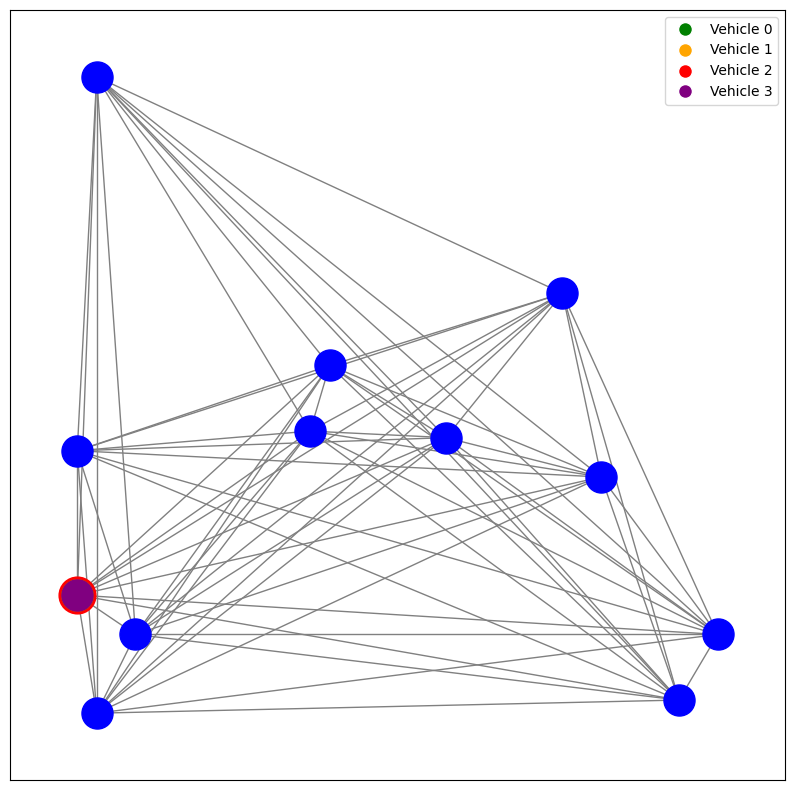

In [14]:
G = nx.Graph()
# Add nodes to the graph
G.add_nodes_from(Spots['name'])
# Create a dictionary for node positions
pos = {row['name']: row['Cartesian'] for _, row in Spots.iterrows()}

# Add fully connected edges using the timematrixtance matrix
for i in range(len(timematrix)):
    for j in range(i + 1, len(timematrix)):
        node_i = Spots.iloc[i]['name']
        node_j = Spots.iloc[j]['name']
        timematrixtance = timematrix.iloc[i, j]
        G.add_edge(node_i, node_j, weight=timematrixtance)

fig, ax = plt.subplots(figsize=(10, 10))

nx.draw_networkx_nodes(G, pos, ax=ax, node_color='blue', node_size=500)
# Highlight the depot node
nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=[Spots.iloc[0]['name']], node_color='red', node_size=700)
# Draw all edges
nx.draw_networkx_edges(G, pos, ax=ax, edge_color='gray', width=1)

colors = ['green', 'orange', 'red', 'purple']  # Define colors for each vehicle

def update(frame):
    ax.clear()
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color='blue', node_size=500)
    nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=[Spots.iloc[0]['name']], node_color='red', node_size=700)
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color='gray', width=1)

    for vehicle_id, route in routes.items():
        path_length = len(route)
        frame_index = min(frame % path_length, path_length - 1)
        path = route[:frame_index + 1]  # Use integer keys directly

        if len(path) > 1:
            nx.draw_networkx_edges(G, pos, edgelist=[(path[i], path[i + 1]) for i in range(len(path) - 1)],
                                   ax=ax, edge_color=colors[vehicle_id % len(colors)], width=2, alpha=0.7)

        # Plot the vehicle's position
        if path:
            nx.draw_networkx_nodes(G, pos, nodelist=[path[-1]], node_color=colors[vehicle_id % len(colors)],
                                   node_size=500, label=f'Vehicle {vehicle_id}')

    # Add a legend for vehicle colors
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Vehicle {i}') for i, color in enumerate(colors)]
    ax.legend(handles=handles)


fig, ax = plt.subplots(figsize=(10, 10))
ani = FuncAnimation(fig, update, frames=max(len(route) for route in routes.values()), repeat=False, interval=1000)

# Save or show the animation
ani.save('Layout_simulation_parallel.gif', writer='pillow')


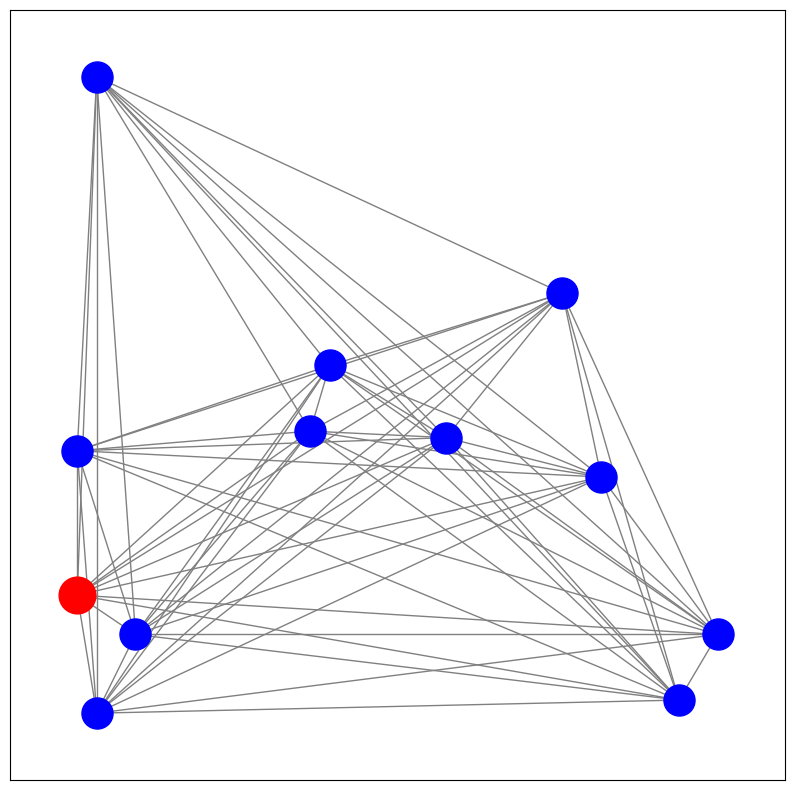

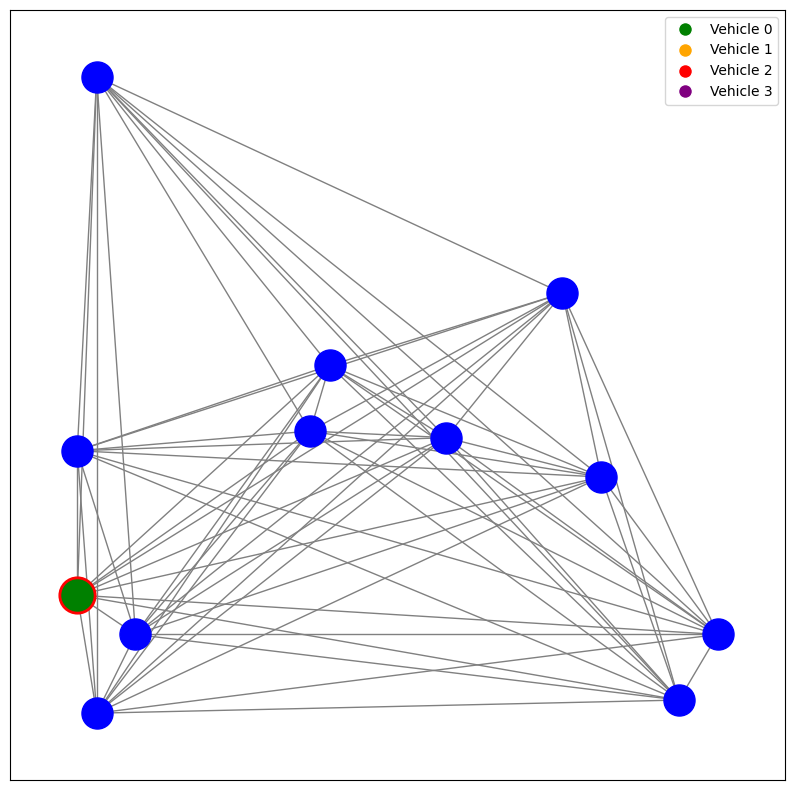

In [15]:
G = nx.Graph()
# Add nodes to the graph
G.add_nodes_from(Spots['name'])
# Create a dictionary for node positions
pos = {row['name']: row['Cartesian'] for _, row in Spots.iterrows()}

# Add fully connected edges using the timematrixtance matrix
for i in range(len(timematrix)):
    for j in range(i + 1, len(timematrix)):
        node_i = Spots.iloc[i]['name']
        node_j = Spots.iloc[j]['name']
        timematrixtance = timematrix.iloc[i, j]
        G.add_edge(node_i, node_j, weight=timematrixtance)

fig, ax = plt.subplots(figsize=(10, 10))

nx.draw_networkx_nodes(G, pos, ax=ax, node_color='blue', node_size=500)
# Highlight the depot node
nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=[Spots.iloc[0]['name']], node_color='red', node_size=700)
# Draw all edges
nx.draw_networkx_edges(G, pos, ax=ax, edge_color='gray', width=1)

colors = ['green', 'orange', 'red', 'purple']  # Define colors for each vehicle

def update(frame):
    ax.clear()
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color='blue', node_size=500)
    nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=[Spots.iloc[0]['name']], node_color='red', node_size=700)
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color='gray', width=1)

    # Determine the current vehicle to display based on the frame
    num_vehicles = len(routes)
    vehicle_id = (frame // (len(max(routes.values(), key=len))) % num_vehicles)

    # Get the route for the current vehicle
    route = routes[vehicle_id]
    path_length = len(route)
    frame_index = min(frame % path_length, path_length - 1)
    path = route[:frame_index + 1]

    # Draw the route for the current vehicle
    if len(path) > 1:
        nx.draw_networkx_edges(G, pos, edgelist=[(path[i], path[i + 1]) for i in range(len(path) - 1)],
                               ax=ax, edge_color=colors[vehicle_id % len(colors)], width=2, alpha=0.7)

    # Plot the vehicle's position
    if path:
        nx.draw_networkx_nodes(G, pos, nodelist=[path[-1]], node_color=colors[vehicle_id % len(colors)],
                               node_size=500, label=f'Vehicle {vehicle_id}')

    # Add a legend for vehicle colors
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Vehicle {i}') for i, color in enumerate(colors)]
    ax.legend(handles=handles)

# Calculate the number of frames needed for the animation
max_frames = len(max(routes.values(), key=len)) * len(routes)

fig, ax = plt.subplots(figsize=(10, 10))
ani = FuncAnimation(fig, update, frames=max_frames, repeat=False, interval=1000)

# Save or show the animation
ani.save('Layout_simulation_sequence.gif', writer='pillow')